In [1]:
import h5py
import importlib
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tensorflow as tf
import yaml
import logomaker
import tfomics
from tfomics import impress, explain, moana

from hominid_pipeline import utils, model_zoo, hominid, layers

2023-06-09 09:48:09.212912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 09:48:10.056024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-09 09:48:10.056100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-09 09:48:10.056108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [34]:
working_dir = "/home/chandana/projects/hominid_pipeline/results"
hits = [
    "experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12",
    "experiments/sweeps/tune_hominid_8f34a_00185_185_conv1_activation=relu,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=softconv_2023-05-18_06-11-38",
    "experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential", # this one!
    "experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential",
    "experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/variations/variation_1"    
]

In [41]:
index = 3
save_path = f"{working_dir}/{hits[index]}"
config_file = f"{working_dir}/{hits[index]}/config.yaml"
config = hominid.load_config(config_file)

tuner = hominid.HominidTuner(
    config, 
    epochs=100, 
    tuning_mode=False, 
    save_path=save_path, 
    subsample=False
)

tuner.save_path

'/home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential'

In [42]:
print(f"python run_gia.py --config_file={config_file}")

python run_gia.py --config_file=/home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/config.yaml


In [4]:
print(f"Loading model and dataset!")

x_test, y_test = tuner.data_processor.load_data("test")

# Build the model
model = tuner.model_builder.build_model()

model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[utils.Spearman, utils.pearson_r]
    )
print(model.summary())
model.load_weights(f'{tuner.save_path}/weights')

print(f"Interpreting filters!")

Loading model and dataset!
Building model...


2023-06-09 09:48:23.534923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 09:48:24.072583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13758 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:81:00.0, compute capability: 8.6


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    253696      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 12,847,938
Trainable params: 12,845,378
Non-trainable params: 2,560
__________________________________________________________________________________________________
None
Interpreting filters!


Loading filters...


In [6]:
layer_index = 3
print(f"rsat matrix-clustering -matrix rsat {tuner.save_path}/filters/filters_{layer_index}_hits.jaspar jaspar -o {tuner.save_path}/filters/filter_clusters/filter_clusters_{layer_index} -v 2")

rsat matrix-clustering -matrix rsat /home/chandana/projects/hominid_pipeline/results/experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12/filters/filters_3_hits.jaspar jaspar -o /home/chandana/projects/hominid_pipeline/results/experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12/filters/filter_clusters/filter_clusters_3 -v 2


In [7]:
# parse the table containing clustered filter indices
cluster_df = pd.read_csv(f"{tuner.save_path}/filters/filter_clusters/filter_clusters_{layer_index}_tables/clusters_motif_names.tab", sep="\t", header=None)
cluster_df.columns = ["cluster_id", "filters"]

rsat_filter_order = []

for index in range(len(cluster_df)):

    filter_list = [i.split("-")[0] for i in cluster_df.loc[index]["filters"].split(",")]
    filter_list = [int(i.split("_")[-1]) for i in filter_list]
    
    rsat_filter_order += filter_list

# store the filter indices in the rsat_filter_order variable
rsat_filter_order

[23,
 167,
 73,
 186,
 17,
 195,
 33,
 66,
 149,
 251,
 22,
 0,
 177,
 58,
 140,
 183,
 12,
 242,
 152,
 21,
 179,
 164,
 122,
 36,
 150,
 83,
 214,
 245,
 161,
 146,
 75,
 240,
 247,
 14,
 221,
 197,
 85,
 208,
 212,
 124,
 226,
 176,
 175,
 11,
 189,
 104,
 72,
 243,
 24,
 170,
 32,
 2,
 90,
 159,
 181,
 108,
 86,
 18,
 220,
 156,
 162,
 201,
 105,
 133,
 198,
 185,
 52,
 192,
 224,
 137,
 206,
 244,
 62,
 69,
 238,
 123,
 147,
 143,
 44,
 207,
 96,
 101,
 15,
 117,
 81,
 205,
 219,
 102,
 89,
 9,
 46,
 193,
 210,
 100,
 97,
 237,
 54,
 121,
 120,
 113,
 3,
 166,
 249,
 174,
 78,
 20,
 61,
 26,
 233,
 84,
 115,
 252,
 60,
 68,
 199,
 246,
 34,
 160,
 74,
 103,
 127,
 8,
 165,
 200,
 107,
 118,
 30,
 56,
 223,
 196,
 38,
 63,
 55,
 232,
 71,
 39,
 222,
 82,
 28,
 53,
 16,
 80,
 248,
 41,
 215,
 145,
 173,
 119,
 204,
 136,
 216,
 180,
 213,
 126,
 42,
 35,
 10,
 79,
 172,
 27,
 40,
 141,
 64,
 76,
 4,
 59,
 169,
 48,
 114,
 236,
 91,
 255,
 129,
 178,
 25,
 77,
 153,
 139,
 57,
 211,


Loading filters...


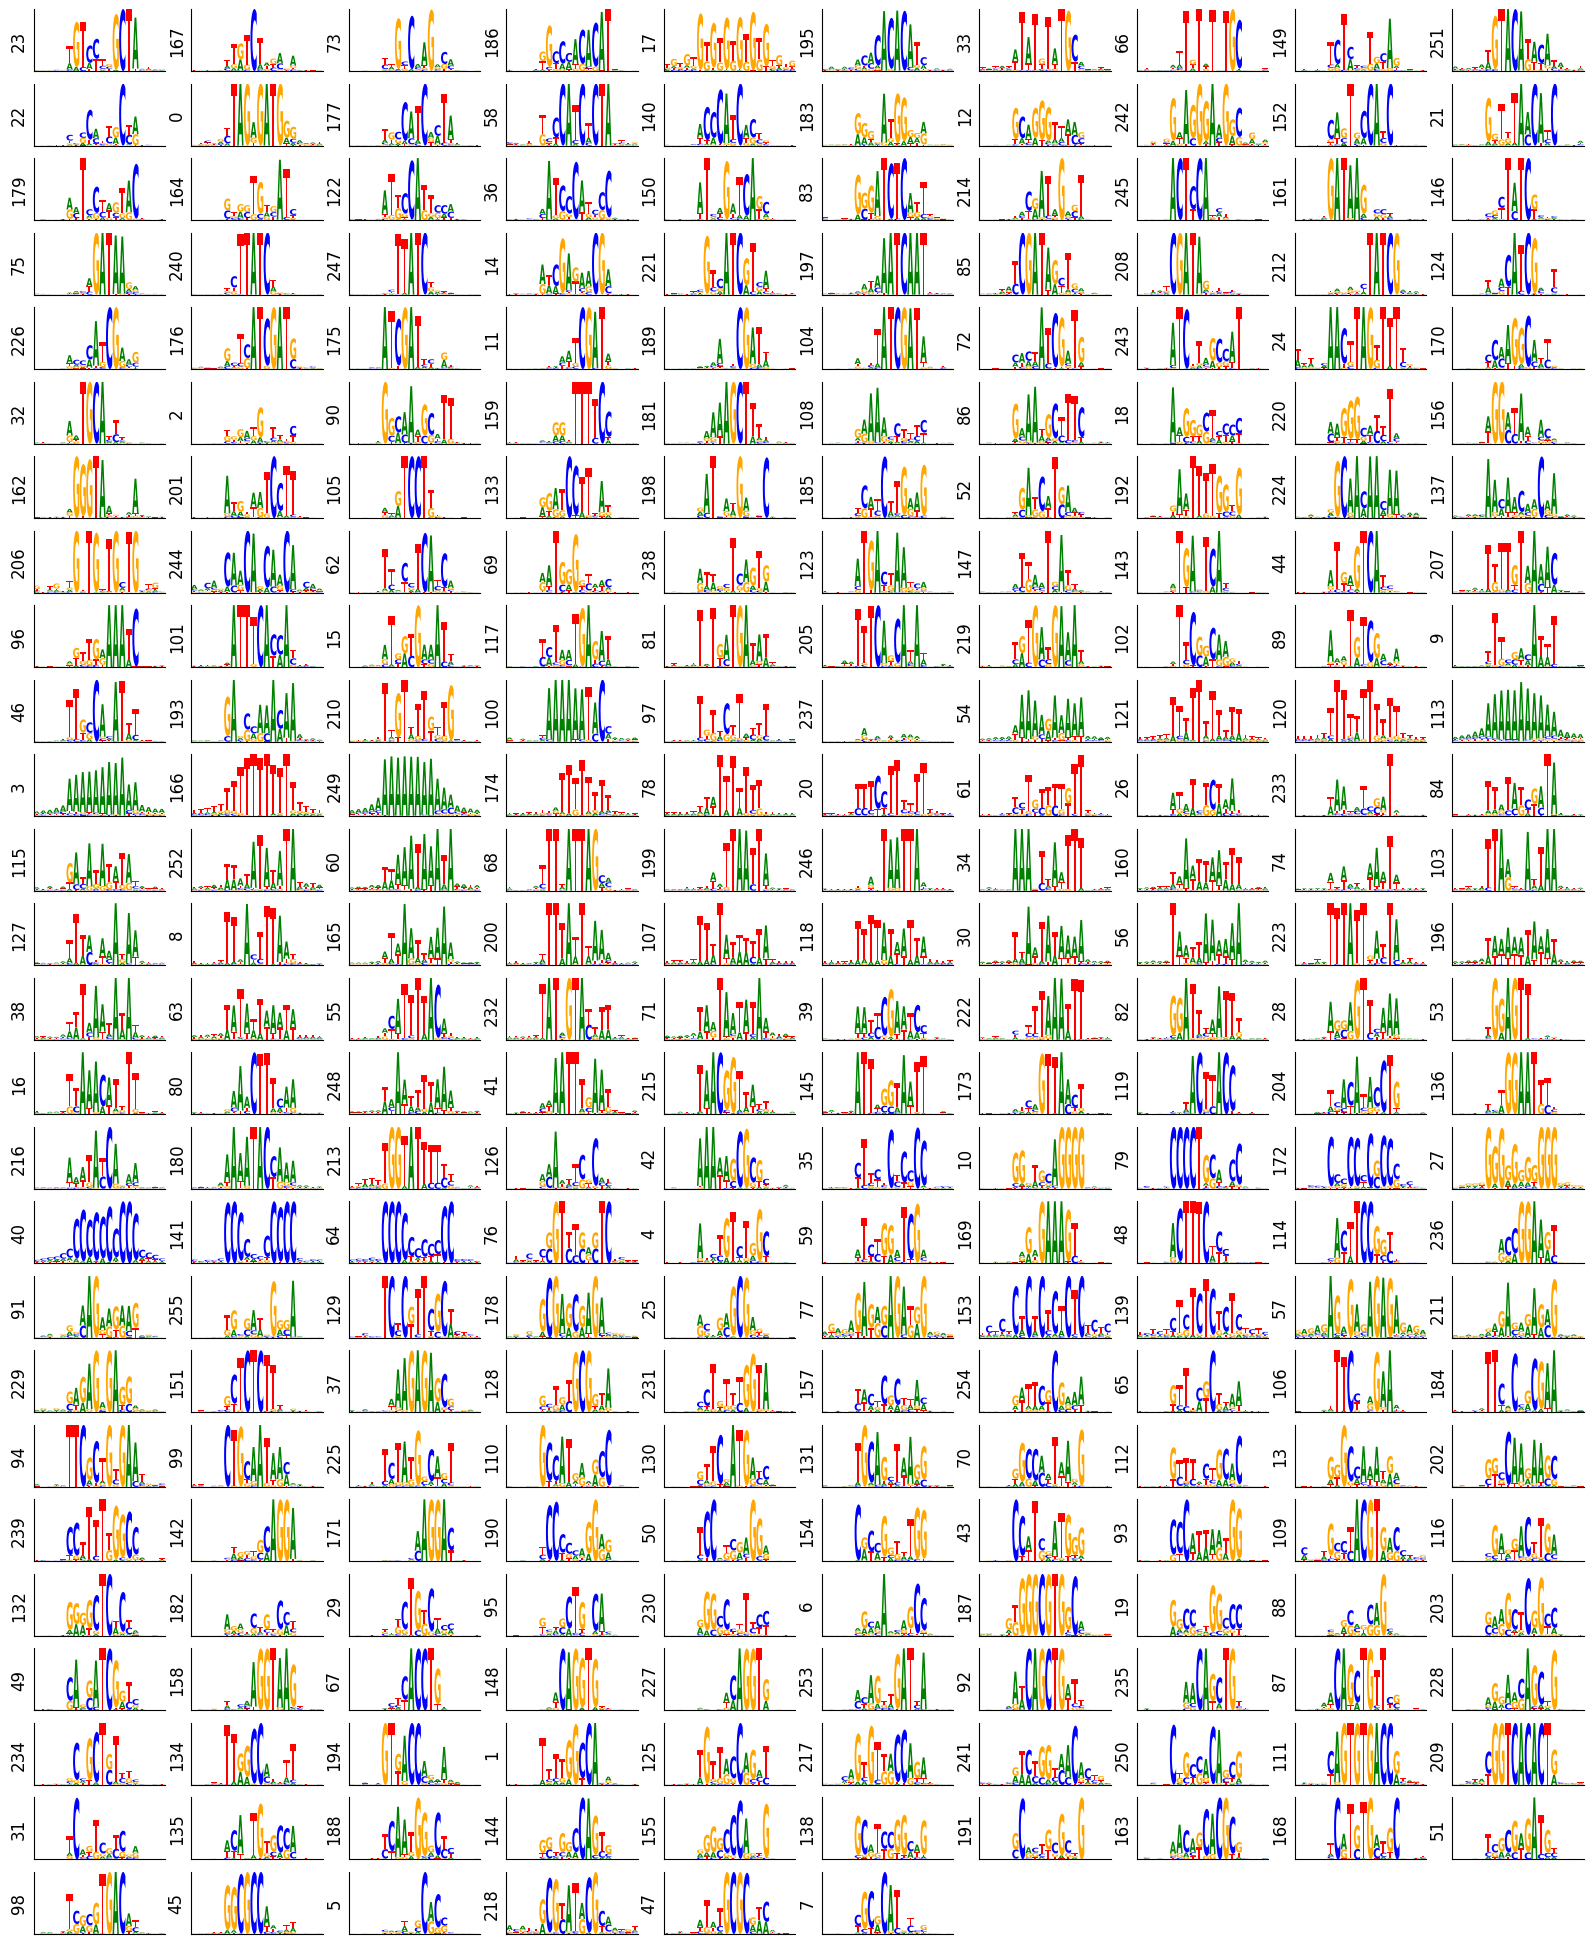

In [8]:
print("Loading filters...")
with h5py.File(f"{tuner.save_path}/filters/filters_{layer_index}.h5", "r") as f:
    W = f["filters"][:]
#     sub_W = f["filters_subset"][:]
#     counts = f["filters"][:]

# plot filters after RSAT clustering:
fig = plt.figure(figsize=(20, model.layers[1].get_weights()[0].shape[-1]//10))
W_df = impress.plot_filters(W[rsat_filter_order], fig, num_cols=10, fontsize=12, names=rsat_filter_order)
# fig.savefig(f"{filters_path}/clustered_filters.pdf", format='pdf', dpi=200, bbox_inches='tight')

Computing saliency maps...


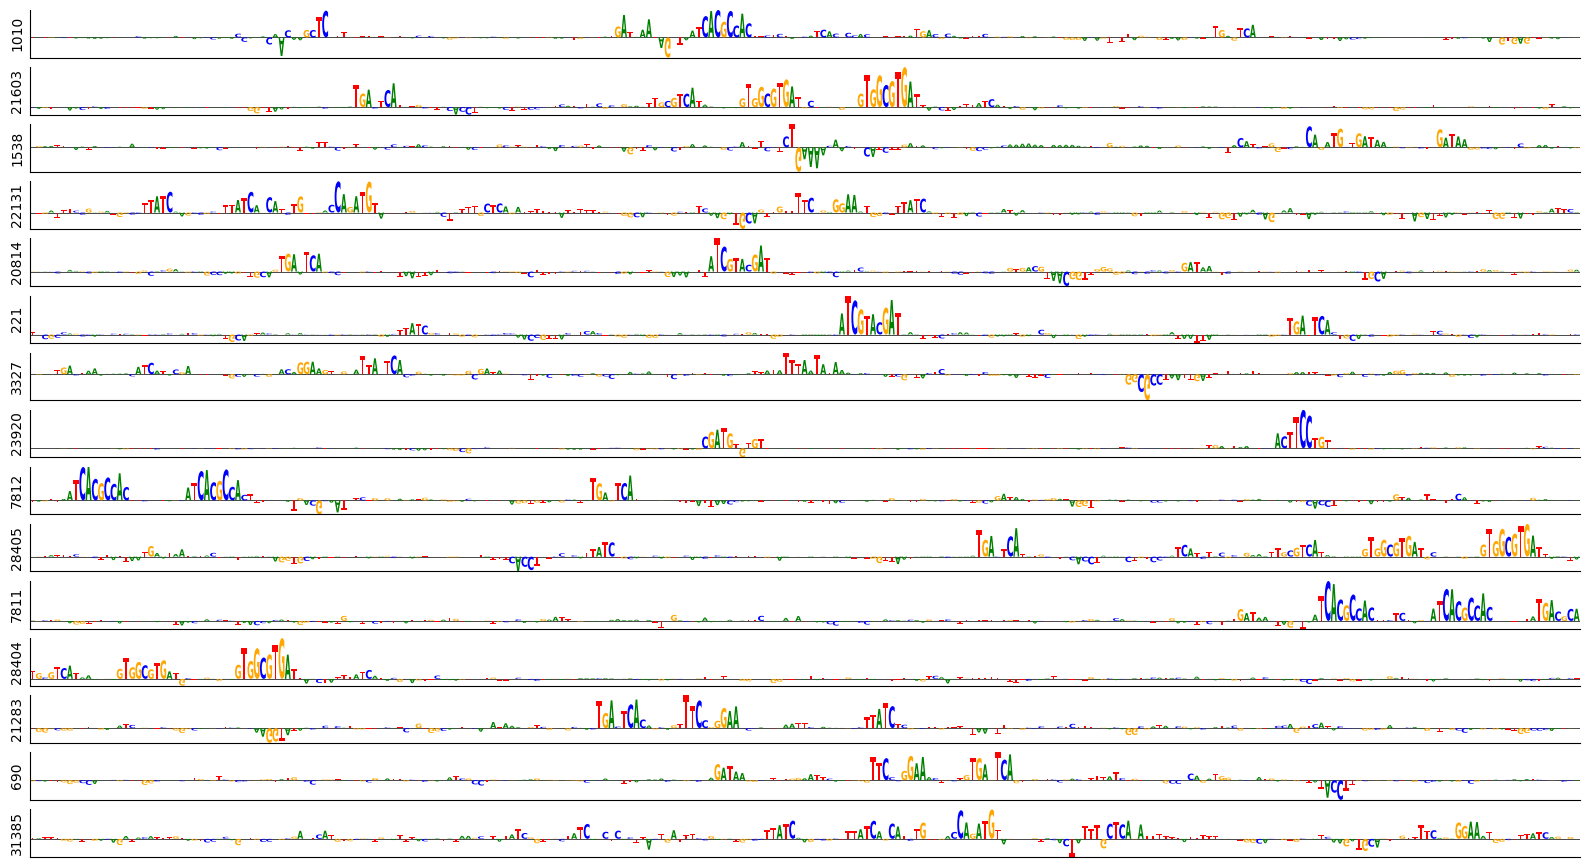

In [11]:
saliency_path = f"{tuner.save_path}/saliency"

print("Computing saliency maps...")
# plot 15 sequences with highest activity for a given class
num_plot = 15

# sort sequences by highest activity
sort = np.argsort(y_test[:,0])[::-1][:num_plot]
X = x_test[sort]

# calculate attribution maps
saliency_path = f"{tuner.save_path}/saliency/saliency_maps_0.pkl"
saliency_scores = utils.load_predictions_from_file(saliency_path)
saliency_scores = np.concatenate(saliency_scores, axis=0)[sort]

# gradient correction. (Majdandzic et al. bioRxiv, 2022)
saliency_scores -= np.mean(saliency_scores, axis=2, keepdims=True)

fig = plt.figure(figsize=(20, 11))
for i, index in enumerate(range(num_plot)):
    x = np.expand_dims(X[index], axis=0)
    scores = np.expand_dims(saliency_scores[index], axis=0)
    scores -= np.mean(scores, axis=2, keepdims=True)
    saliency_df = impress.grad_times_input_to_df(x, scores)

    ax = plt.subplot(num_plot,1,i+1)
    impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    253696      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 12,847,938
Trainable params: 12,845,378
Non-trainable params: 2,560
__________________________________________________________________________________________________


In [22]:
lays

[keras.engine.input_layer.InputLayer,
 hominid_pipeline.layers.PairwiseConv1D,
 keras.layers.normalization.batch_normalization.BatchNormalization,
 keras.layers.core.activation.Activation,
 keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D,
 keras.layers.core.dense.Dense,
 keras.layers.core.dense.Dense,
 keras.layers.reshaping.reshape.Reshape,
 keras.layers.core.tf_op_layer.TFOpLambda,
 keras.layers.regularization.dropout.Dropout,
 hominid_pipeline.layers.MultiHeadAttention,
 hominid_pipeline.layers.MultiHeadAttention,
 keras.layers.regularization.dropout.Dropout,
 keras.layers.regularization.dropout.Dropout,
 keras.layers.reshaping.flatten.Flatten,
 keras.layers.reshaping.flatten.Flatten,
 keras.layers.core.dense.Dense,
 keras.layers.core.dense.Dense,
 keras.layers.normalization.batch_normalization.BatchNormalization,
 keras.layers.normalization.batch_normalization.BatchNormalization,
 keras.layers.core.activation.Activation,
 keras.layers.core.activation.Activation

In [23]:
lays.index(layers.MultiHeadAttention)

10

In [25]:
# for this model ONLY: challenges are that there is no pooling layer
# so selected the concatenation layer for the conv_layer
import time
t1 = time.time()
sample = x_test[:5000]
lays = [type(i) for i in model.layers]
c_index = lays.index(keras.layers.core.tf_op_layer.TFOpLambda) #lays.index(tf.keras.layers.MaxPool1D)

mha_index = lays.index(layers.MultiHeadAttention)
correlation_map = utils.correlation_matrix(
                            model, 
                            c_index, 
                            mha_index, 
                            sample, 
                            thresh=0.1, 
                            random_frac=0.3, 
                            limit=150000
                        )
t2 = time.time()

print(f"Time taken: {t2-t1}")

157/157 [==============================] - 1s 1ms/step


2023-06-09 10:02:25.701055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


157/157 [==============================] - 1s 3ms/step


/home/chandana/projects/hominid_pipeline/hominid_pipeline/utils.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_pairs].transpose([1, 2, 0])


Time taken: 507.90930819511414


In [27]:
# save correlation map to an h5 file
glifac_path = f"{tuner.save_path}/glifac"
utils.make_directory(glifac_path)

file_path = f"{glifac_path}/correlation_map.h5"
with h5py.File(file_path, "w") as f:
    dset = f.create_dataset(name="correlation_map", data=correlation_map, dtype='float32')

In [28]:
len(rsat_filter_order)

256

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f9f4443f710>)

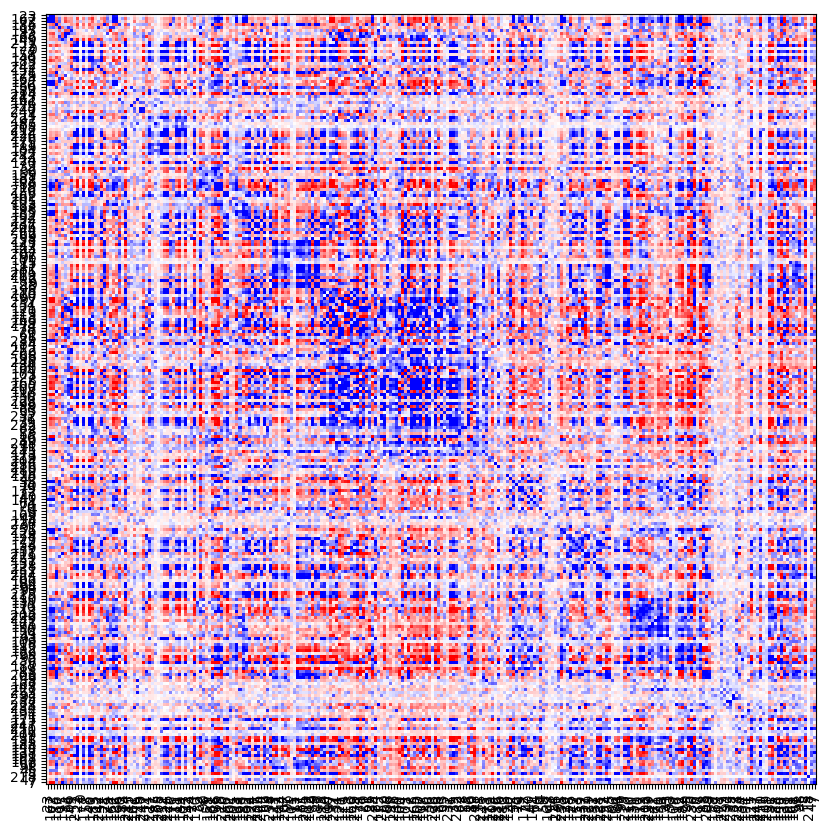

In [29]:
# create heatmap (only showing 25 filters here)
motif_order = rsat_filter_order
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
utils.plot_glifac(
                    ax,
                    np.clip(correlation_map, -1, 1)[motif_order][:,motif_order],
                    motif_order,
                    vmin=-0.15,
                    vmax=0.15
                )
# fig.savefig(f'{glifac_path}/glifac_interactions.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
# create heatmap (only showing 25 filters here)
motif_order = rsat_filter_order
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
utils.plot_glifac(
                    ax,
                    np.clip(correlation_map, -1, 1)[motif_order][:,motif_order],
                    motif_order,
                    vmin=-0.15,
                    vmax=0.15
                )
# fig.savefig(f'{glifac_path}/glifac_interactions.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [30]:
from hominid_pipeline import gia_utils

In [31]:
alphabet = 'ACGT'
gia = gia_utils.GlobalImportance(model, alphabet)
gia.set_null_model('random', base_sequence=x_test, num_sample=2000, base_scores=y_test[:,0])  
gia.filter_null(low=10, high=90, num_sample=1000)

32/32 [==============================] - 0s 6ms/step


In [ ]:
position = 125
class_index = 0

print('ap1')
ap1 = 'NNTCACGCANN'
ap1_flank_scores, ap1_flanks = gia.optimal_flanks(ap1, position, class_index)
ap1 = ap1_flanks[0]

print('dre')
dre = 'NNTATCGATATANN'
dre_flank_scores, dre_flanks = gia.optimal_flanks(dre, position, class_index)
dre = dre_flanks[0]

print('dref')
dref = 'NNCGATGGNN'
dref_flank_scores, dref_flanks = gia.optimal_flanks(dref, position, class_index)
dref = dref_flanks[0]

print('gata')
gata = 'NNGATAANN'
gata_flank_scores, gata_flanks = gia.optimal_flanks(gata, position, class_index)
gata = gata_flanks[0]

print('gata_rc')
gata_rc = 'NNTTATCNN'
gata_rc_flank_scores, gata_rc_flanks = gia.optimal_flanks(gata_rc, position, class_index)
gata_rc = gata_rc_flanks[0]

print('ohler5')
ohler5 = 'NNCAGCTGNN'
ohler5_flank_scores, ohler5_flanks = gia.optimal_flanks(ohler5, position, class_index)
ohler5 = ohler5_flanks[0]

print('ohler7')
ohler7 = 'NNCATCGCTGNN'
ohler7_flank_scores, ohler7_flanks = gia.optimal_flanks(ohler7, position, class_index)
ohler7 = ohler7_flanks[0]

print('mitf')
mitf = 'NNTCACGTGANN'
mitf_flank_scores, mitf_flanks = gia.optimal_flanks(mitf, position, class_index)
mitf = mitf_flanks[0]

print('ohler1')
ohler1 = 'NCAGTGTGACCGN'
ohler1_flank_scores, ohler1_flanks = gia.optimal_flanks(ohler1, position, class_index)
ohler1 = ohler1_flanks[0]

print('ohler1_rc')
ohler1_rc = 'NCGGTCACACTGN'
ohler1_rc_flank_scores, ohler1_rc_flanks = gia.optimal_flanks(ohler1_rc, position, class_index)
ohler1_rc = ohler1_rc_flanks[0]


flank_scores0 = {
    'ap1': ap1_flank_scores,
    'dre': dre_flank_scores,
    'dref': dref_flank_scores,
    'gata': gata_flank_scores,
    'gata_rc': gata_rc_flank_scores,
    'ohler5': ohler5_flank_scores,
    'ohler7': ohler7_flank_scores,
    'mitf': mitf_flank_scores,
    'ohler1': ohler1_flank_scores,
    'ohler1_rc': ohler1_rc_flank_scores,
}

flanks0 = {
    'ap1': ap1_flanks,
    'dre': dre_flanks,
    'dref': dref_flanks,
    'gata': gata_flanks,
    'gata_rc': gata_rc_flanks,
    'ohler5': ohler5_flanks,
    'ohler7': ohler7_flanks,
    'mitf': mitf_flanks,
    'ohler1': ohler1_flanks,
    'ohler1_rc': ohler1_rc_flanks,
}

motifs0 = {
    'ap1': ap1,
    'dre': dre,
    'dref': dref,
    'gata': gata,
    'gata_rc': gata_rc,
    'ohler5': ohler5,
    'ohler7': ohler7,
    'mitf': mitf,
    'ohler1': ohler1,
    'ohler1_rc': ohler1_rc,
    'ohler6': 'AAAATACCAAA',
    'ohler6_rc': 'TTTGGTATTTTT',
    'stat': 'TTCCCGGAA',
    'ts01': 'AAATTTAAAA',
    'cebp': 'TGGTGAAAT',
    'at': 'AATAAA',
    'ga': 'GAGAGAGAGAGA',
    'ct': 'CTCTCTCTCTCT',
    'myb': 'CGCG',
    'context': 'GGGCT',
}


In [ ]:
position = 125
class_index = 1

print('ap1')
ap1 = 'NNTCACGCANN'
ap1_flank_scores, ap1_flanks = gia.optimal_flanks(ap1, position, class_index)
ap1 = ap1_flanks[0]

print('dre')
dre = 'NNTATCGATATANN'
dre_flank_scores, dre_flanks = gia.optimal_flanks(dre, position, class_index)
dre = dre_flanks[0]

print('dref')
dref = 'NNCGATGGNN'
dref_flank_scores, dref_flanks = gia.optimal_flanks(dref, position, class_index)
dref = dref_flanks[0]

print('gata')
gata = 'NNGATAANN'
gata_flank_scores, gata_flanks = gia.optimal_flanks(gata, position, class_index)
gata = gata_flanks[0]

print('gata_rc')
gata_rc = 'NNTTATCNN'
gata_rc_flank_scores, gata_rc_flanks = gia.optimal_flanks(gata_rc, position, class_index)
gata_rc = gata_rc_flanks[0]

print('ohler5')
ohler5 = 'NNCAGCTGNN'
ohler5_flank_scores, ohler5_flanks = gia.optimal_flanks(ohler5, position, class_index)
ohler5 = ohler5_flanks[0]

print('ohler7')
ohler7 = 'NNCATCGCTGNN'
ohler7_flank_scores, ohler7_flanks = gia.optimal_flanks(ohler7, position, class_index)
ohler7 = ohler7_flanks[0]

print('mitf')
mitf = 'NNTCACGTGANN'
mitf_flank_scores, mitf_flanks = gia.optimal_flanks(mitf, position, class_index)
mitf = mitf_flanks[0]

print('ohler1')
ohler1 = 'NCAGTGTGACCGN'
ohler1_flank_scores, ohler1_flanks = gia.optimal_flanks(ohler1, position, class_index)
ohler1 = ohler1_flanks[0]

print('ohler1_rc')
ohler1_rc = 'NCGGTCACACTGN'
ohler1_rc_flank_scores, ohler1_rc_flanks = gia.optimal_flanks(ohler1_rc, position, class_index)
ohler1_rc = ohler1_rc_flanks[0]


flank_scores1 = {
    'ap1': ap1_flank_scores,
    'dre': dre_flank_scores,
    'dref': dref_flank_scores,
    'gata': gata_flank_scores,
    'gata_rc': gata_rc_flank_scores,
    'ohler5': ohler5_flank_scores,
    'ohler7': ohler7_flank_scores,
    'mitf': mitf_flank_scores,
    'ohler1': ohler1_flank_scores,
    'ohler1_rc': ohler1_rc_flank_scores,
}

flanks1 = {
    'ap1': ap1_flanks,
    'dre': dre_flanks,
    'dref': dref_flanks,
    'gata': gata_flanks,
    'gata_rc': gata_rc_flanks,
    'ohler5': ohler5_flanks,
    'ohler7': ohler7_flanks,
    'mitf': mitf_flanks,
    'ohler1': ohler1_flanks,
    'ohler1_rc': ohler1_rc_flanks,
}

motifs1 = {
    'ap1': ap1,
    'dre': dre,
    'dref': dref,
    'gata': gata,
    'gata_rc': gata_rc,
    'ohler5': ohler5,
    'ohler7': ohler7,
    'mitf': mitf,
    'ohler1': ohler1,
    'ohler1_rc': ohler1_rc,
    'ohler6': 'AAAATACCAAA',
    'ohler6_rc': 'TTTGGTATTTTT',
    'stat': 'TTCCCGGAA',
    'ts01': 'AAATTTAAAA',
    'cebp': 'TGGTGAAAT',
    'at': 'AATAAA',
    'ga': 'GAGAGAGAGAGA',
    'ct': 'CTCTCTCTCTCT',
    'myb': 'CGCG',
    'context': 'GGGCT',
}


In [ ]:
start = 50
end = 200
class_index = 0

print('ap1')
ap1_pos_scores, ap1_pos = gia.optimal_position(motifs0['ap1'], start, end, class_index)
ap1_index = ap1_pos[np.argmax(np.mean(ap1_pos_scores, axis=1))]

print('dre')
dre_pos_scores, dre_pos = gia.optimal_position(motifs0['dre'], start, end, class_index)
dre_index = dre_pos[np.argmax(np.mean(dre_pos_scores, axis=1))]

print('dref')
dref_pos_scores, dref_pos = gia.optimal_position(motifs0['dref'], start, end, class_index)
dref_index = dref_pos[np.argmax(np.mean(dref_pos_scores, axis=1))]

print('gata')
gata_pos_scores, gata_pos = gia.optimal_position(motifs0['gata'], start, end, class_index)
gata_index = gata_pos[np.argmax(np.mean(gata_pos_scores, axis=1))]

print('gata_rc')
gata_rc_pos_scores, gata_rc_pos = gia.optimal_position(motifs0['gata_rc'], start, end, class_index)
gata_rc_index = gata_rc_pos[np.argmax(np.mean(gata_rc_pos_scores, axis=1))]

print('ohler5')
ohler5_pos_scores, ohler5_pos = gia.optimal_position(motifs0['ohler5'], start, end, class_index)
ohler5_index = ohler5_pos[np.argmax(np.mean(ohler5_pos_scores, axis=1))]

print('ohler7')
ohler7_pos_scores, ohler7_pos = gia.optimal_position(motifs0['ohler7'], start, end, class_index)
ohler7_index = ohler7_pos[np.argmax(np.mean(ohler7_pos_scores, axis=1))]

print('mitf')
mitf_pos_scores, mitf_pos = gia.optimal_position(motifs0['mitf'], start, end, class_index)
mitf_index = mitf_pos[np.argmax(np.mean(mitf_pos_scores, axis=1))]

print('ohler1')
ohler1_pos_scores, ohler1_pos = gia.optimal_position(motifs0['ohler1'], start, end, class_index)
ohler1_index = ohler1_pos[np.argmax(np.mean(ohler1_pos_scores, axis=1))]

print('ohler1_rc')
ohler1_rc_pos_scores, ohler1_rc_pos = gia.optimal_position(motifs0['ohler1_rc'], start, end, class_index)
ohler1_rc_index = ohler1_rc_pos[np.argmax(np.mean(ohler1_rc_pos_scores, axis=1))]

print('ohler6')
ohler6_pos_scores, ohler6_pos = gia.optimal_position(motifs0['ohler6'], start, end, class_index)
ohler6_index = ohler6_pos[np.argmax(np.mean(ohler6_pos_scores, axis=1))]

print('ohler6_rc')
ohler6_rc_pos_scores, ohler6_rc_pos = gia.optimal_position(motifs0['ohler6_rc'], start, end, class_index)
ohler6_rc_index = ohler6_rc_pos[np.argmax(np.mean(ohler6_rc_pos_scores, axis=1))]

print('stat')
stat_pos_scores, stat_pos = gia.optimal_position(motifs0['stat'], start, end, class_index)
stat_index = stat_pos[np.argmax(np.mean(stat_pos_scores, axis=1))]

print('ts01')
ts01_pos_scores, ts01_pos = gia.optimal_position(motifs0['ts01'], start, end, class_index)
ts01_index = ts01_pos[np.argmax(np.mean(ts01_pos_scores, axis=1))]

print('cebp')
cebp_pos_scores, cebp_pos = gia.optimal_position(motifs0['cebp'], start, end, class_index)
cebp_index = cebp_pos[np.argmax(np.mean(cebp_pos_scores, axis=1))]

pos_scores0 = {
    'ap1': ap1_pos_scores,
    'dre': dre_pos_scores,
    'dref': dref_pos_scores,
    'gata': gata_pos_scores,
    'gata_rc': gata_rc_pos_scores,
    'ohler5': ohler5_pos_scores,
    'ohler7': ohler7_pos_scores,
    'mitf': mitf_pos_scores,
    'ohler1': ohler1_pos_scores,
    'ohler1_rc': ohler1_rc_pos_scores,
    'ohler6': ohler6_pos_scores,
    'ohler6_rc': ohler6_rc_pos_scores,
    'stat': stat_pos_scores,
    'ts01': ts01_pos_scores,
    'cebp': cebp_pos_scores,
}

pos_index0 = {
    'ap1': ap1_index,
    'dre': dre_index,
    'dref': dref_index,
    'gata': gata_index,
    'gata_rc': gata_rc_index,
    'ohler5': ohler5_index,
    'ohler7': ohler7_index,
    'mitf': mitf_index,
    'ohler1': ohler1_index,
    'ohler1_rc': ohler1_rc_index,
    'ohler6': ohler6_index,
    'ohler6_rc': ohler6_rc_index,
    'stat': stat_index,
    'ts01': ts01_index,
    'cebp': cebp_index,
}

In [ ]:
start = 50
end = 200
class_index = 1

print('ap1')
ap1_pos_scores, ap1_pos = gia.optimal_position(motifs1['ap1'], start, end, class_index)
ap1_index = ap1_pos[np.argmax(np.mean(ap1_pos_scores, axis=1))]

print('dre')
dre_pos_scores, dre_pos = gia.optimal_position(motifs1['dre'], start, end, class_index)
dre_index = dre_pos[np.argmax(np.mean(dre_pos_scores, axis=1))]

print('dref')
dref_pos_scores, dref_pos = gia.optimal_position(motifs1['dref'], start, end, class_index)
dref_index = dref_pos[np.argmax(np.mean(dref_pos_scores, axis=1))]

print('gata')
gata_pos_scores, gata_pos = gia.optimal_position(motifs1['gata'], start, end, class_index)
gata_index = gata_pos[np.argmax(np.mean(gata_pos_scores, axis=1))]

print('gata_rc')
gata_rc_pos_scores, gata_rc_pos = gia.optimal_position(motifs1['gata_rc'], start, end, class_index)
gata_rc_index = gata_rc_pos[np.argmax(np.mean(gata_rc_pos_scores, axis=1))]

print('ohler5')
ohler5_pos_scores, ohler5_pos = gia.optimal_position(motifs1['ohler5'], start, end, class_index)
ohler5_index = ohler5_pos[np.argmax(np.mean(ohler5_pos_scores, axis=1))]

print('ohler7')
ohler7_pos_scores, ohler7_pos = gia.optimal_position(motifs1['ohler7'], start, end, class_index)
ohler7_index = ohler7_pos[np.argmax(np.mean(ohler7_pos_scores, axis=1))]

print('mitf')
mitf_pos_scores, mitf_pos = gia.optimal_position(motifs1['mitf'], start, end, class_index)
mitf_index = mitf_pos[np.argmax(np.mean(mitf_pos_scores, axis=1))]

print('ohler1')
ohler1_pos_scores, ohler1_pos = gia.optimal_position(motifs1['ohler1'], start, end, class_index)
ohler1_index = ohler1_pos[np.argmax(np.mean(ohler1_pos_scores, axis=1))]

print('ohler1_rc')
ohler1_rc_pos_scores, ohler1_rc_pos = gia.optimal_position(motifs1['ohler1_rc'], start, end, class_index)
ohler1_rc_index = ohler1_rc_pos[np.argmax(np.mean(ohler1_rc_pos_scores, axis=1))]

print('ohler6')
ohler6_pos_scores, ohler6_pos = gia.optimal_position(motifs1['ohler6'], start, end, class_index)
ohler6_index = ohler6_pos[np.argmax(np.mean(ohler6_pos_scores, axis=1))]

print('ohler6_rc')
ohler6_rc_pos_scores, ohler6_rc_pos = gia.optimal_position(motifs1['ohler6_rc'], start, end, class_index)
ohler6_rc_index = ohler6_rc_pos[np.argmax(np.mean(ohler6_rc_pos_scores, axis=1))]

print('stat')
stat_pos_scores, stat_pos = gia.optimal_position(motifs1['stat'], start, end, class_index)
stat_index = stat_pos[np.argmax(np.mean(stat_pos_scores, axis=1))]

print('ts01')
ts01_pos_scores, ts01_pos = gia.optimal_position(motifs1['ts01'], start, end, class_index)
ts01_index = ts01_pos[np.argmax(np.mean(ts01_pos_scores, axis=1))]

print('cebp')
cebp_pos_scores, cebp_pos = gia.optimal_position(motifs1['cebp'], start, end, class_index)
cebp_index = cebp_pos[np.argmax(np.mean(cebp_pos_scores, axis=1))]

pos_scores1 = {
    'ap1': ap1_pos_scores,
    'dre': dre_pos_scores,
    'dref': dref_pos_scores,
    'gata': gata_pos_scores,
    'gata_rc': gata_rc_pos_scores,
    'ohler5': ohler5_pos_scores,
    'ohler7': ohler7_pos_scores,
    'mitf': mitf_pos_scores,
    'ohler1': ohler1_pos_scores,
    'ohler1_rc': ohler1_rc_pos_scores,
    'ohler6': ohler6_pos_scores,
    'ohler6_rc': ohler6_rc_pos_scores,
    'stat': stat_pos_scores,
    'ts01': ts01_pos_scores,
    'cebp': cebp_pos_scores,
}

pos_index1 = {
    'ap1': ap1_index,
    'dre': dre_index,
    'dref': dref_index,
    'gata': gata_index,
    'gata_rc': gata_rc_index,
    'ohler5': ohler5_index,
    'ohler7': ohler7_index,
    'mitf': mitf_index,
    'ohler1': ohler1_index,
    'ohler1_rc': ohler1_rc_index,
    'ohler6': ohler6_index,
    'ohler6_rc': ohler6_rc_index,
    'stat': stat_index,
    'ts01': ts01_index,
    'cebp': cebp_index,
}

In [ ]:
pairs = [
    #'ohler1_rc-dre',
    #'dre-ohler1_rc',
    'dre-ohler1',
    'ohler1_rc-ohler6_rc',
    'ohler7-dre',
    'dre-ohler7', 
    'ohler7-dref',
    'dref-ohler7',
    'gata-ap1',
    'gata_rc-ap1',
    'ap1-gata',
    'ap1-gata_rc',
    #'gata-ct',
    #'gata_rc-ct',
    #'gata-ga',
    #'gata_rc-ga',
    'ohler1-dre',
    
    'ohler1-ohler6',
    'ohler1-ohler6_rc',
    'ohler1_rc-ohler6',
    'ohler6-ohler1',
    'ohler6-ohler1_rc',
    'ohler6_rc-ohler1',
    'ohler6_rc-ohler1_rc',
    'ohler6-dre',
    'ohler6_rc-dre',
    'stat-ts01',
    'ts01-stat',
    'cebp-ohler1',
    'ohler1-cebp',
    'ohler5-mitf',
    'mitf-ohler5',
    'mitf-ohler1',
    'mitf-ohler6',
    'mitf-ohler7',
    'mitf-gata',
    'mitf-stat',
    'mitf-cebp',
    'gata-context',
    'ohler1-context',
    'ohler6-context',
    'ohler7-context',
    'dre-context',
    'ts01-myb',
    'mitf-myb',
    'ohler7-myb',
    'dre-ap1',
    'ap1-dre',
    'ohler1-ap1',
    'ohler1_rc-ap1',
    'ap1-ohler1',
    'ap1-ohler1_rc',
    'dre-gata',
    'dre-gata_rc',
    'gata-dre',
    'gata_rc-dre',
    'ohler6-at',
    'ohler6_rc-at',
]


interact_scores0 = {}
interact_pos_scores0 = {}
for pair in pairs:
    print(pair)
    motif1, motif2 = pair.split('-')
    scores, pos_scores = optimal_interactions(gia, motifs0[motif1], pos_index0[motif1], motifs0[motif2], window_scan=50, class_index=0)
    interact_scores0[pair] = scores
    interact_pos_scores0[pair] = pos_scores
    

interact_scores1 = {}
interact_pos_scores1 = {}
for pair in pairs:
    print(pair)
    motif1, motif2 = pair.split('-')
    scores, pos_scores = optimal_interactions(gia, motifs1[motif1], pos_index1[motif1], motifs0[motif2], window_scan=50, class_index=1)
    interact_scores1[pair] = scores
    interact_pos_scores1[pair] = pos_scores

In [ ]:
from six.moves import cPickle

with open('glifac_deepstarr_gia_results.pickle', 'wb') as fout:
    cPickle.dump(motifs0, fout)
    cPickle.dump(flanks0, fout)
    cPickle.dump(flank_scores0, fout)
    cPickle.dump(pos_scores0, fout)
    cPickle.dump(pos_index0, fout)
    cPickle.dump(interact_scores0, fout)
    cPickle.dump(interact_pos_scores0, fout)
    cPickle.dump(motifs1, fout)
    cPickle.dump(flanks1, fout)
    cPickle.dump(flank_scores1, fout)
    cPickle.dump(pos_scores1, fout)
    cPickle.dump(pos_index1, fout)
    cPickle.dump(interact_scores1, fout)
    cPickle.dump(interact_pos_scores1, fout)
    

In [33]:
pos_scores, pos = gia.optimal_position('GATAA', start=50, end=200, class_index=0)
gata_index0 = pos[np.argmax(np.mean(pos_scores, axis=1))]

pos_scores, pos = gia.optimal_position('TTATC', start=50, end=200, class_index=0)
gata_rc_index0 = pos[np.argmax(np.mean(pos_scores, axis=1))]


motif1 = 'TTATC'
motif2 = 'AGAGAGAG'
scores, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_rc_index0, motif2, window_scan=50, class_index=0)

motif1 = 'TTATC'
motif2 = 'CTCTCTCT'
scores2, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_rc_index0, motif2, window_scan=50, class_index=0)

motif1 = 'GATAA'
motif2 = 'AGAGAGAG'
scores3, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_index0, motif2, window_scan=50, class_index=0)

motif1 = 'GATAA'
motif2 = 'CTCTCTCT'
scores4, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_index0, motif2, window_scan=50, class_index=0)


32/32 [==============================] - 0s 6ms/step


32/32 [==============================] - 0s 6ms/step


In [ ]:

motif1 = 'GATAA'
motif2 = 'AGAGAGAG'
scores3, pos_scores = optimal_interactions(gia, motif1, gata_index0, motif2, window_scan=50, class_index=0)


motif1 = 'TTATC'
motif2 = 'AGAGAGAG'
scores, pos_scores = optimal_interactions(gia, motif1, gata_rc_index0, motif2, window_scan=50, class_index=0)


In [ ]:
from six.moves import cPickle

with open('glifac_gata_results.pickle', 'wb') as fout:
    cPickle.dump(scores, fout)
    cPickle.dump(scores2, fout)
    cPickle.dump(scores3, fout)
    cPickle.dump(scores4, fout)

In [ ]:

results = [
    scores3[0] - np.mean(scores3[1]) - np.mean(scores3[2]),
    scores4[0] - np.mean(scores4[1]) - np.mean(scores4[2]),
    scores[0] - np.mean(scores[1]) - np.mean(scores[2]), 
    scores2[0] - np.mean(scores2[1]) - np.mean(scores2[2]),
]

fontsize = 12
fig = plt.figure(figsize=(4,3))
box_violin_plot(results, cmap='tab10', ylabel='Importance', xlabel=None, title=None, fontsize=fontsize)
plt.axhline(0, 0, 3, linestyle='--', color='black')
#plt.ylim([-.5, 1.5])

ax = plt.gca();
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.yticks([-1, 0.0, 1, 2], fontsize=fontsize)
#plt.xticks([50, 100, 150, 200], fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(1,5), ['GATA::AG', 'GATA::CT', 'GATA_rc::AG', 'GATA_rc::CT'], fontsize=fontsize, rotation=45, ha='right', rotation_mode='anchor')
plt.ylim([-1,2])

fig.savefig('gata_context_comparison.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:

results = [
    scores3[0] - np.mean(scores3[1]) - np.mean(scores3[2]),
    scores4[0] - np.mean(scores4[1]) - np.mean(scores4[2]),
    scores[0] - np.mean(scores[1]) - np.mean(scores[2]), 
    scores2[0] - np.mean(scores2[1]) - np.mean(scores2[2]),
]

fontsize = 12
fig = plt.figure(figsize=(4,3))
box_violin_plot(results, cmap='tab10', ylabel='Importance', xlabel=None, title=None, fontsize=fontsize)
plt.axhline(0, 0, 3, linestyle='--', color='black')
#plt.ylim([-.5, 1.5])

ax = plt.gca();
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.yticks([-1, 0.0, 1, 2], fontsize=fontsize)
#plt.xticks([50, 100, 150, 200], fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(1,5), ['GATA::AG', 'GATA::CT', 'GATA_rc::AG', 'GATA_rc::CT'], fontsize=fontsize, rotation=45, ha='right', rotation_mode='anchor')
plt.ylim([-1,2])

fig.savefig('gata_context_comparison_deepstarr.pdf', format='pdf', dpi=200, bbox_inches='tight')